# Modeling

For the interpretation of findings + business implications, see [RESULTS.md](RESULTS.md).

## Modeling Approach Justification

**Objective:**  
Identify structural barriers to residential solar adoption across U.S. counties, conditional on sufficient solar resource and mature technology.

**Target Variable:**  
`log_adoption_rate_pop` — log-transformed residential adoption rate per 1,000 population.

This target is used instead of total installed capacity because it captures adoption breadth (how widely households participate) rather than adoption depth (how much capacity is installed). For example, a county with many small systems reflects broader access than a county with a few large systems, even if total installed capacity is the same.

**Feature Set:**  
Continuous socioeconomic variables (income, education, population density, racial/ethnic composition), and binary policy indicators (net metering, incentive programs).

**Model Choice:** Elastic Net Regression  

**Justification:**
- **Interpretability:** Like ordinary least squares (OLS), coefficients provide a clear understanding of how each feature affects log adoption rates.
- **Feature Selection & Stability:** Elastic Net combines L1 (Lasso) and L2 (Ridge) regularization, mitigating overfitting and stabilizing coefficients in the presence of correlated predictors.
- **Robustness to Correlation:** Unlike pure Lasso, Elastic Net distributes coefficient weight across correlated variables, preventing arbitrary exclusion of important barriers.
- **Actionable Insights:** Coefficients can be interpreted as percent changes in adoption rate per standard deviation change in a feature, directly informing policy implications.

**Alternatives Considered:**
- OLS linear regression: fully interpretable but unstable with correlated predictors.
- Lasso regression: strong feature selection but may arbitrarily drop correlated variables.
- Tree-based models (Random Forest / Gradient Boosting): capture nonlinearities but less interpretable (possible extension appraoch).

> **Summary:** Elastic Net provides a balance of interpretability, stability, and actionable insights, making it well-suited for analyzing structural barriers to solar adoption at the county level.

### Implemented Preprocessing Steps

All preprocessing decisions below are backed by findings from the EDA notebook.

#### 1. **Missing Data Handling**
- **Decision:** Excluded `avg_daily_sunlight` from final model
- **Rationale:** EDA showed 51% missing data and R² < 1% explanatory power for log-transformed target
- **Alternative attempted:** Mean imputation was tested but variable ultimately dropped

#### 2. **Outlier Treatment**
- **Method:** Winsorization (capping at 1st and 99th percentiles)
- **Applied to:** All numeric predictors
- **Rationale (from EDA):**
  - Preserves sample size (no data loss from deletion)
  - Reduces influence of extreme values while retaining information
  - Geographic outliers (e.g., NYC high density) represent real phenomena, not errors
  - Elastic Net is robust to outliers, but winsorization adds extra stability

#### 3. **Feature Transformations**
- **Log transformations applied:**
  - `log_population_density` ← population_density + 1
  - `log_median_income` ← median_household_income
  - `log_total_programs` ← total_solar_programs + 1
  - `log_pct_black` ← pct_black + 0.1 (handle zeros)
  - `log_pct_hispanic` ← pct_hispanic + 0.1 (handle zeros)
  
- **Rationale (from EDA):**
  - These features were right-skewed (long tail toward high values)
  - Log transformation compresses right tail → more symmetric distribution
  - Improves linearity with target and reduces influence of extreme values

- **Left-skewed features left unchanged:**
  - `single_family_home_pct`, `homeownership_rate`, `pct_white_non_hispanic`
  - Log transformation only works for right-skewed data
  - Elastic Net regularization handles remaining skewness

#### 4. **Feature Selection**
- **Excluded:** `avg_daily_sunlight` (justification above)
- **Included but noted:** `has_net_metering`, `has_solar_incentive`
  - EDA flagged these as potentially constant (little variation)
  - Kept in model as they represent policy conditions of interest
  - Elastic Net's L1 penalty will shrink coefficients to zero if uninformative

#### 5. **Categorical Encoding**
- **Method:** One-hot encoding for `urbanicity` with `drop_first=True`
- **Result:** Creates dummy variables (Urban, Suburban) with Rural as reference category
- **Rationale:** Avoids multicollinearity (dummy variable trap)

#### 6. **Train/Test Split Strategy**
- **Method:** Stratified sampling by adoption level (quartiles)
- **Split ratio:** 80% train, 20% test
- **Rationale:**
  - Ensures both sets have proportional representation across adoption levels
  - Prevents test set from being concentrated in high/low adoption counties
  - Improves generalization and prevents biased performance estimates

#### 7. **Feature Standardization**
- **Method:** StandardScaler (mean=0, std=1) fitted on training data only
- **Applied to:** Continuous features only (not binary or dummy variables)
- **Rationale:**
  - **Critical for Elastic Net:** L1/L2 penalties must be applied fairly across features
  - Features on different scales would be penalized unequally
  - Binary/dummy variables kept at {0,1} scale for interpretability

#### 8. **Multicollinearity Handling**
- **Decision:** Use Elastic Net regression (not PCA or manual feature dropping)
- **Rationale (from EDA):**
  - PCA loses interpretability (creates linear combinations)
  - Elastic Net's L1 penalty (Lasso component) performs automatic feature selection
  - L2 penalty (Ridge component) stabilizes coefficients for correlated predictors
  - Trade-off accepted: Maintain interpretability over perfect coefficient stability

In [22]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# Scikit-learn
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

# Configure display
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
sns.set_style('whitegrid')

print(" Libraries loaded")

 Libraries loaded


## 1. Load Data

In [23]:
# Load merged dataset from data preparation notebook
data_path = Path('modeling_data/merged_solar_dataset.csv')
df = pd.read_csv(data_path)

print("=" * 70)
print("Dataset Loaded")
print("=" * 70)
print(f"\nShape: {df.shape}")
print(f"Counties: {len(df):,}")
print(f"\nColumns: {df.columns.tolist()}")

print("\nFirst 5 rows:")
df.head()

Dataset Loaded

Shape: (1279, 17)
Counties: 1,279

Columns: ['adoption_rate_per_1k_pop', 'log_adoption_rate_pop', 'total_capacity_kw_weighted', 'median_household_income', 'homeownership_rate', 'single_family_home_pct', 'pct_bachelors_or_higher', 'pct_white_non_hispanic', 'pct_black', 'pct_hispanic', 'avg_household_size', 'population_density', 'urbanicity', 'has_net_metering', 'has_solar_incentive', 'total_solar_programs', 'avg_daily_sunlight']

First 5 rows:


,adoption_rate_per_1k_pop,log_adoption_rate_pop,total_capacity_kw_weighted,median_household_income,homeownership_rate,single_family_home_pct,pct_bachelors_or_higher,pct_white_non_hispanic,pct_black,pct_hispanic,avg_household_size,population_density,urbanicity,has_net_metering,has_solar_incentive,total_solar_programs,avg_daily_sunlight
0,0.001493,-4.466008,5.640000,64589.0,63.717364,71.231045,35.936761,47.947723,42.324829,5.241256,2.41,602.537021,Suburban,0.0,1.0,12.0,16607.77
1,0.006913,-4.079675,4.759524,83534.0,77.496814,80.150390,30.391301,73.516644,12.589122,7.236677,2.61,190.941136,Rural,0.0,1.0,12.0,16159.39
2,0.000645,-4.542624,1.640476,83528.0,68.776813,74.135849,45.690291,62.321880,23.961625,6.533798,2.37,495.426658,Suburban,0.0,1.0,12.0,16049.50
3,1.080947,0.087046,426.873585,40338.0,79.133030,70.649288,15.268524,18.585566,0.947016,6.230207,3.14,5.865169,Rural,1.0,1.0,62.0,18657.88
4,16.532900,2.805957,13889.504581,58970.0,70.500832,68.741570,27.657715,54.571251,3.232157,34.335794,2.37,20.203022,Rural,1.0,1.0,62.0,20240.65


## 2. Data Quality Check

In [24]:
# Check for missing values
print("=" * 70)
print("Missing Values Assessment")
print("=" * 70)

missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing_Count': missing,
    'Missing_Percent': missing_pct
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\n  Found missing values in {len(missing_df)} columns:")
    print(missing_df)
else:
    print("\n No missing values found!")

# Data types
print("\n" + "=" * 70)
print("Data Types")
print("=" * 70)
print(df.dtypes)

Missing Values Assessment

  Found missing values in 1 columns:
                    Missing_Count  Missing_Percent
avg_daily_sunlight            647            50.59

Data Types
adoption_rate_per_1k_pop      float64
log_adoption_rate_pop         float64
total_capacity_kw_weighted    float64
median_household_income       float64
homeownership_rate            float64
single_family_home_pct        float64
pct_bachelors_or_higher       float64
pct_white_non_hispanic        float64
pct_black                     float64
pct_hispanic                  float64
avg_household_size            float64
population_density            float64
urbanicity                     object
has_net_metering              float64
has_solar_incentive           float64
total_solar_programs          float64
avg_daily_sunlight            float64
dtype: object


In [25]:
# Handle missing values in avg_daily_sunlight (mean imputation)

print("=" * 70)
print("Handling Missing Values: avg_daily_sunlight")
print("=" * 70)

# Check missing data before imputation
missing_before = df['avg_daily_sunlight'].isnull().sum()
missing_pct_before = (missing_before / len(df) * 100).round(2)

print(f"\nMissing values before imputation:")
print(f"  Count: {missing_before:,} ({missing_pct_before}%)")
print(f"  Available: {df['avg_daily_sunlight'].notna().sum():,}")

# Calculate mean from available data
sunlight_mean = df['avg_daily_sunlight'].mean()
print(f"\nMean sunlight (from available data): {sunlight_mean:.2f} KJ/m²")

# Impute missing values with mean
df['avg_daily_sunlight'].fillna(sunlight_mean, inplace=True)

# Verify imputation
missing_after = df['avg_daily_sunlight'].isnull().sum()
print(f"\n Missing values after imputation: {missing_after}")

# Show distribution before/after
print(f"\nSunlight distribution after imputation:")
print(df['avg_daily_sunlight'].describe())

# Optional: Create a flag for imputed values (useful for sensitivity analysis)
df['sunlight_imputed'] = df['avg_daily_sunlight'] == sunlight_mean

imputed_count = df['sunlight_imputed'].sum()
print(f"\n Created 'sunlight_imputed' flag:")
print(f"   Counties with imputed sunlight: {imputed_count:,} ({imputed_count/len(df)*100:.1f}%)")
print(f"   Counties with real sunlight: {(~df['sunlight_imputed']).sum():,}")

print("\n" + "=" * 70)
print(" Imputation Complete")
print("=" * 70)

Handling Missing Values: avg_daily_sunlight

Missing values before imputation:
  Count: 647 (50.59%)
  Available: 632

Mean sunlight (from available data): 16206.86 KJ/m²

 Missing values after imputation: 0

Sunlight distribution after imputation:
count     1279.000000
mean     16206.863022
std       1379.984714
min      13130.090000
25%      15630.975000
50%      16206.863022
75%      16206.863022
max      20774.770000
Name: avg_daily_sunlight, dtype: float64

 Created 'sunlight_imputed' flag:
   Counties with imputed sunlight: 647 (50.6%)
   Counties with real sunlight: 632

 Imputation Complete


/var/folders/rs/nq6c88xs43j3xx3wd29dm_cr0000gn/T/ipykernel_19972/3271406741.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['avg_daily_sunlight'].fillna(sunlight_mean, inplace=True)


## 3. Feature Selection & Preprocessing

**Features for modeling:**

**Outcome variable:**
- `log_adoption_rate_pop` - Residential adoption rate (per 1,000 population) log transformed

**Predictor variables:**
- **Economic:** `median_household_income`
- **Housing:** `homeownership_rate`, `single_family_home_pct`, `avg_household_size`
- **Demographics:** `pct_bachelors_or_higher`, `pct_white_non_hispanic`, `pct_black`, `pct_hispanic`
- **Geography:** `population_density`, `urbanicity` (categorical)
- **Policy:** `total_solar_programs`, `has_net_metering`, `has_solar_incentive` (binary)

### 3.1 Handle Outliers

In [26]:
numeric_predictors = [
    'median_household_income', 'homeownership_rate', 'single_family_home_pct',
    'pct_bachelors_or_higher', 'pct_white_non_hispanic', 'pct_black', 
    'pct_hispanic', 'avg_household_size', 'population_density', 'total_population',
    'has_net_metering', 'has_solar_incentive', 'total_solar_programs'
]

numeric_predictors = [col for col in numeric_predictors if col in df.columns]

# Winsorize (cap at 1st/99th percentile)
from scipy.stats import mstats
for col in numeric_predictors:
    df[col] = mstats.winsorize(df[col], limits=[0.01, 0.01])


### 3.2 Transform Skewed Features

In [27]:
# Log-transform right-skewed continuous variables
df['log_population_density'] = np.log(df['population_density'] + 1)
df['log_median_income'] = np.log(df['median_household_income'])
df['log_total_programs'] = np.log(df['total_solar_programs'] + 1)

# For racial composition (handle zeros):
df['log_pct_black'] = np.log(df['pct_black'] + 0.1)
df['log_pct_hispanic'] = np.log(df['pct_hispanic'] + 0.1)

# Left-skewed (long tail toward LOW values) - log doesn't help here
# single_family_home_pct: skew = -1.47
# homeownership_rate: skew = -1.20
# pct_white_non_hispanic: skew = -1.15

# Leave as-is (Elastic Net handles this via regularization)

In [28]:
# Define outcome and feature columns
outcome_var =  'log_adoption_rate_pop'   # 'log_adoption_rate_pop', 'adoption_rate_per_1k_pop', 'total_capacity_kw_weighted'

# Continuous features (will be standardized)
continuous_features = [
    'homeownership_rate',
    'single_family_home_pct',
    'avg_household_size',
    'pct_bachelors_or_higher',
    'pct_white_non_hispanic',

    # Raw features
    # 'median_household_income',
    # 'pct_black',
    # 'pct_hispanic',
    # 'population_density',
     'total_solar_programs',

    #Log transformed features
    'log_median_income',
    'log_pct_black',
    'log_pct_hispanic',
    'log_population_density',
    #'log_total_programs',

    # Control
    #'avg_daily_sunlight',

]

# Categorical features (will be one-hot encoded)
categorical_features = ['urbanicity']

# Binary features - Comment out to remove constant features (model can handle them, but they add no info)
binary_features = ['has_solar_incentive', 'has_net_metering']

print("Feature categories defined:")
print(f"  Continuous: {len(continuous_features)} features")
print(f"  Categorical: {len(categorical_features)} features")
print(f"  Binary: {len(binary_features)} features")

Feature categories defined:
  Continuous: 10 features
  Categorical: 1 features
  Binary: 2 features


In [29]:
# Create modeling dataset with only required columns
modeling_cols = [outcome_var] + continuous_features + categorical_features + binary_features
df_model = df[modeling_cols].copy()

print("Modeling dataset created")
print(f"Shape: {df_model.shape}")

print(f"\nFinal modeling dataset: {len(df_model):,} counties")

Modeling dataset created
Shape: (1279, 14)

Final modeling dataset: 1,279 counties


### 3.3 One-Hot Encode Categorical Features

In [30]:
# One-hot encode urbanicity (drop first to avoid multicollinearity)
df_encoded = pd.get_dummies(df_model, columns=categorical_features, drop_first=True, dtype=int)

print("One-hot encoding complete")
print(f"Original shape: {df_model.shape}")
print(f"Encoded shape: {df_encoded.shape}")

# Show new dummy columns
dummy_cols = [col for col in df_encoded.columns if 'urbanicity' in col]
print(f"\nDummy variables created: {dummy_cols}")

print("\nSample of encoded data:")
df_encoded.head()

One-hot encoding complete
Original shape: (1279, 14)
Encoded shape: (1279, 15)

Dummy variables created: ['urbanicity_Suburban', 'urbanicity_Urban']

Sample of encoded data:


,log_adoption_rate_pop,homeownership_rate,single_family_home_pct,avg_household_size,pct_bachelors_or_higher,pct_white_non_hispanic,total_solar_programs,log_median_income,log_pct_black,log_pct_hispanic,log_population_density,has_solar_incentive,has_net_metering,urbanicity_Suburban,urbanicity_Urban
0,-4.466008,63.717364,71.231045,2.41,35.936761,47.947723,12.0,11.075799,3.747734,1.675461,6.402807,1.0,1.0,1,0
1,-4.079675,77.496814,80.150390,2.61,30.391301,73.516644,12.0,11.333009,2.540745,1.992886,5.257189,1.0,1.0,0,0
2,-4.542624,68.776813,74.135849,2.37,45.690291,62.321880,12.0,11.332937,3.180618,1.892178,6.207436,1.0,1.0,1,0
3,0.087046,79.133030,70.649288,3.14,15.268524,18.585566,62.0,10.605049,0.045944,1.845333,1.926461,1.0,1.0,0,0
4,2.805957,70.500832,68.741570,2.37,27.657715,54.571251,62.0,10.984784,1.203620,3.539097,3.054144,1.0,1.0,0,0


### 3.4 Split into Features (X) and Outcome (y)

In [31]:
# Separate outcome and features
y = df_encoded[outcome_var]
X = df_encoded.drop(columns=[outcome_var])

print("Features (X) and outcome (y) separated")
print(f"  X shape: {X.shape}")
print(f"  y shape: {y.shape}")

print(f"\nFeature names ({len(X.columns)} total):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

print(f"\nOutcome variable statistics:")
print(y.describe())

Features (X) and outcome (y) separated
  X shape: (1279, 14)
  y shape: (1279,)

Feature names (14 total):
   1. homeownership_rate
   2. single_family_home_pct
   3. avg_household_size
   4. pct_bachelors_or_higher
   5. pct_white_non_hispanic
   6. total_solar_programs
   7. log_median_income
   8. log_pct_black
   9. log_pct_hispanic
  10. log_population_density
  11. has_solar_incentive
  12. has_net_metering
  13. urbanicity_Suburban
  14. urbanicity_Urban

Outcome variable statistics:
count    1279.000000
mean       -0.203095
std         2.375102
min        -4.605145
25%        -2.111087
50%        -0.051428
75%         1.673256
max         4.865928
Name: log_adoption_rate_pop, dtype: float64


### 3.5 Train/Test Split

In [32]:
# Create adoption level bins for stratification
# This ensures both train and test have full range of adoption patterns
df_encoded['adoption_quartile'] = pd.qcut(
    df_encoded['log_adoption_rate_pop'], 
    q=4, 
    labels=['Very Low', 'Low', 'Medium', 'High']
)

print("Adoption quartile distribution:")
print(df_encoded['adoption_quartile'].value_counts().sort_index())

# Separate outcome and features
y = df_encoded['log_adoption_rate_pop']
X = df_encoded.drop(columns=['log_adoption_rate_pop', 'adoption_quartile'])
stratify_labels = df_encoded['adoption_quartile']

# Split with stratification by adoption level
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    stratify=stratify_labels,  # Ensures proportional representation across adoption levels
    random_state=42
)

print(f"\n Stratified split complete")
print(f"  Training set: {len(X_train):,} counties")
print(f"  Test set: {len(X_test):,} counties")

# Verify stratification worked
train_quartiles = stratify_labels.iloc[X_train.index].value_counts().sort_index()
test_quartiles = stratify_labels.iloc[X_test.index].value_counts().sort_index()

print(f"\nAdoption level distribution:")
print(f"{'Quartile':<15} {'Train':<10} {'Test':<10} {'Train %':<10} {'Test %':<10}")
print("=" * 60)
for q in ['Very Low', 'Low', 'Medium', 'High']:
    train_n = train_quartiles.get(q, 0)
    test_n = test_quartiles.get(q, 0)
    train_pct = (train_n / len(X_train) * 100)
    test_pct = (test_n / len(X_test) * 100)
    print(f"{q:<15} {train_n:<10} {test_n:<10} {train_pct:>6.1f}%    {test_pct:>6.1f}%")

print("Train/Test Split Complete")
print(f"  Training set: {X_train.shape[0]:,} counties ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"  Test set:     {X_test.shape[0]:,} counties ({X_test.shape[0]/len(X)*100:.1f}%)")

print(f"\nOutcome distribution:")
print(f"  Train mean: {y_train.mean():.2f}")
print(f"  Test mean:  {y_test.mean():.2f}")

Adoption quartile distribution:
adoption_quartile
Very Low    320
Low         320
Medium      319
High        320
Name: count, dtype: int64

 Stratified split complete
  Training set: 1,023 counties
  Test set: 256 counties

Adoption level distribution:
Quartile        Train      Test       Train %    Test %    
Very Low        256        64           25.0%      25.0%
Low             256        64           25.0%      25.0%
Medium          255        64           24.9%      25.0%
High            256        64           25.0%      25.0%
Train/Test Split Complete
  Training set: 1,023 counties (80.0%)
  Test set:     256 counties (20.0%)

Outcome distribution:
  Train mean: -0.22
  Test mean:  -0.14


### 3.6 Standardize Continuous Features

**Critical for Elastic Net:** Standardization ensures all features are on the same scale (mean=0, std=1), making L1/L2 penalties fair across features.

In [33]:
# Identify which columns need standardization (continuous features)
# Binary and dummy variables should NOT be standardized
cols_to_standardize = continuous_features.copy()

# Initialize scaler (fit on training data only!)
scaler = StandardScaler()

# Fit scaler on training data and transform both train and test
X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[cols_to_standardize] = scaler.fit_transform(X_train[cols_to_standardize])
X_test_scaled[cols_to_standardize] = scaler.transform(X_test[cols_to_standardize])

print("Standardization complete")
print(f"  Features standardized: {len(cols_to_standardize)}")
print(f"  Features standardized: {cols_to_standardize}")

print(f"\nVerify standardization (training set):")
print(f"  Mean (should be ~0): {X_train_scaled[cols_to_standardize].mean().mean():.6f}")
print(f"  Std (should be ~1):  {X_train_scaled[cols_to_standardize].std().mean():.6f}")

print(f"\nSample of standardized features:")
X_train_scaled.head()

Standardization complete
  Features standardized: 10
  Features standardized: ['homeownership_rate', 'single_family_home_pct', 'avg_household_size', 'pct_bachelors_or_higher', 'pct_white_non_hispanic', 'total_solar_programs', 'log_median_income', 'log_pct_black', 'log_pct_hispanic', 'log_population_density']

Verify standardization (training set):
  Mean (should be ~0): -0.000000
  Std (should be ~1):  1.000489

Sample of standardized features:


,homeownership_rate,single_family_home_pct,avg_household_size,pct_bachelors_or_higher,pct_white_non_hispanic,total_solar_programs,log_median_income,log_pct_black,log_pct_hispanic,log_population_density,has_solar_incentive,has_net_metering,urbanicity_Suburban,urbanicity_Urban
9,-0.257665,-3.475691,-1.848804,-1.194782,-0.709891,0.049828,-1.370367,-1.329781,1.086372,-1.705559,1.0,1.0,0,0
965,-0.674913,0.084123,-0.029910,-0.186420,-0.993563,0.694328,-0.220543,0.194703,1.492438,-0.014303,1.0,1.0,0,0
709,-0.796102,-0.682113,-0.029910,-1.131937,1.064058,-0.623967,-1.366703,-0.573858,-2.061170,-0.157569,1.0,1.0,0,0
100,-1.248387,-0.096986,-0.110750,1.074629,-0.342846,3.477394,1.134354,-0.556421,1.051705,0.035120,1.0,1.0,0,0
1037,0.731196,0.858843,-0.191589,-0.350697,0.763574,-0.623967,0.521987,0.359519,-0.608767,0.000030,1.0,1.0,0,0


## 4. Elastic Net Regression with Cross-Validation

**Hyperparameters:**
- `alpha`: Overall regularization strength (higher = more penalty)
- `l1_ratio`: Mix between L1 (Lasso) and L2 (Ridge)
  - `l1_ratio=1.0` → Pure Lasso (feature selection)
  - `l1_ratio=0.0` → Pure Ridge (shrinkage)
  - `l1_ratio=0.5` → Equal mix (Elastic Net)

### Training Methodology

**Cost Function:**  
Elastic Net minimizes Mean Squared Error (MSE) with combined L1 and L2 regularization:

$$\text{Cost} = \text{MSE} + \alpha \times \left[ \ell_1\text{-ratio} \times \text{L1} + (1 - \ell_1\text{-ratio}) \times \text{L2} \right]$$

Where:
- **MSE** = Mean of squared prediction errors (goodness of fit)
- **L1 penalty** = Sum of absolute coefficients (feature selection, sparse models)
- **L2 penalty** = Sum of squared coefficients (coefficient shrinkage, stability)
- **alpha** = Overall regularization strength
- **l1_ratio** = Mix between L1 and L2 (0 = pure Ridge, 1 = pure Lasso, 0.5 = balanced)

**3-Level Data Splitting:**

1. **Train/Test Split (80/20):** Initial stratified split ensures both sets have proportional representation across adoption levels
2. **Cross-Validation (5-fold):** Training set is further divided into 5 folds for hyperparameter tuning
   - Each fold serves as validation set once while other 4 train the model
   - Average performance across folds determines best hyperparameters
3. **Final Evaluation:** Best model is evaluated once on the held-out test set (never seen during training/tuning)

**Hyperparameter Tuning:**  
GridSearchCV tests all combinations of alpha (6 values) × l1_ratio (6 values) = 36 models using 5-fold CV to select optimal regularization.

In [34]:
# Define hyperparameter grid
param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0],  # Regularization strength
    'l1_ratio': [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]      # L1/L2 mix
}

print("Hyperparameter Grid:")
print(f"  alpha: {param_grid['alpha']}")
print(f"  l1_ratio: {param_grid['l1_ratio']}")
print(f"  Total combinations: {len(param_grid['alpha']) * len(param_grid['l1_ratio'])}")

# Initialize Elastic Net model
elastic_net = ElasticNet(max_iter=10000, random_state=42)

# Grid search with 5-fold cross-validation
print("\nRunning Grid Search with 5-fold CV...")
grid_search = GridSearchCV(
    estimator=elastic_net,
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

# Fit grid search
grid_search.fit(X_train_scaled, y_train)

print("\n Grid Search Complete!")

Hyperparameter Grid:
  alpha: [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
  l1_ratio: [0.1, 0.3, 0.5, 0.7, 0.9, 1.0]
  Total combinations: 36

Running Grid Search with 5-fold CV...
Fitting 5 folds for each of 36 candidates, totalling 180 fits

 Grid Search Complete!


### 4.1 Best Model & Hyperparameters

In [35]:
# Best hyperparameters
print("=" * 70)
print("Best Hyperparameters (from Cross-Validation)")
print("=" * 70)
print(f"\nalpha (regularization strength): {grid_search.best_params_['alpha']}")
print(f"l1_ratio (L1/L2 mix): {grid_search.best_params_['l1_ratio']}")

if grid_search.best_params_['l1_ratio'] == 1.0:
    print("  → Pure Lasso (L1) - Performs feature selection")
elif grid_search.best_params_['l1_ratio'] == 0.0:
    print("  → Pure Ridge (L2) - Shrinks all coefficients")
else:
    print("  → Elastic Net - Balanced L1 + L2 penalty")

print(f"\nBest CV Score (negative MSE): {grid_search.best_score_:.2f}")
print(f"Best CV RMSE: {np.sqrt(-grid_search.best_score_):.2f}")

# Extract best model
best_model = grid_search.best_estimator_
print(f"\n Best model extracted")

Best Hyperparameters (from Cross-Validation)

alpha (regularization strength): 0.01
l1_ratio (L1/L2 mix): 0.1
  → Elastic Net - Balanced L1 + L2 penalty

Best CV Score (negative MSE): -4.64
Best CV RMSE: 2.16

 Best model extracted


### 4.2 Model Performance on Test Set

In [36]:
# Predictions on test set
y_pred = best_model.predict(X_test_scaled)

# Back transform predictions to original scale
y_test_orig = np.exp(y_test)
y_pred_orig = np.exp(y_pred)

# =========================
# Model Evaluation Metrics
# =========================
# Goal: Identify top predictive features (barriers/enablers) of solar adoption
# rather than predict exact county-level values. Metrics are reported for context.

# We evaluate performance on BOTH:
# 1) Log-transformed target (what the model is trained on)
# 2) Original scale (what is substantively meaningful for interpretation)

# -------------------------
# LOG-SCALE METRICS
# -------------------------
# Log-transformed target stabilizes variance due to right-skewed adoption
# and multiplicative growth (e.g., adoption doubles with income or incentives).
# Metrics on this scale reflect relative errors and variance explained.

mse_log = mean_squared_error(y_test, y_pred)
rmse_log = np.sqrt(mse_log) # Penalizes large errors more heavily; sensitive to outliers
mae_log = mean_absolute_error(y_test, y_pred) # Typical error magnitude, robust to outliers
r2 = r2_score(y_test, y_pred) # Primary metric: proportion of variance explained

# Interpretation:
# - R² (log): Proportion of variance explained in log(adoption).
#   • R² ≈ 0   → model explains little beyond the mean
#   • R² > 0.2 → meaningful signal for noisy social data
#   • Negative → worse than predicting the mean
#
# - RMSE (log): Typical multiplicative error magnitude. 
#   • Square root of the mean of the squared differences between the model values and the true values
#   • Can be interpreted approximately as a % error:
#     RMSE ≈ 0.7 (ln 2) → predictions off by ~2× on average
#
# - MAE (log): Median-like robustness; less sensitive to outliers.
#   • Lower MAE than RMSE suggests some large errors but reasonable typical fit


# -------------------------
# ORIGINAL-SCALE METRICS
# -------------------------
# Back-transformed predictions reflect actual adoption units.
# RMSE shows sensitivity to extreme counties, MAE shows typical absolute error.

mse_orig = mean_squared_error(y_test_orig, y_pred_orig)
rmse_orig = np.sqrt(mse_orig)
mae_orig = mean_absolute_error(y_test_orig, y_pred_orig)

# Interpretation:
# - RMSE (orig): Penalizes large absolute errors more heavily.
#   • Useful for understanding worst-case prediction magnitude
#
# - MAE (orig): Typical absolute error in original units.
#   • Compare directly to the mean of the outcome to judge scale
#
# NOTE:
# Large RMSE/MAE on original scale is common when the target is highly skewed.
# This does NOT necessarily mean the model is useless for identifying drivers.


print("=" * 70)
print("Model Performance on Test Set")
print("=" * 70)

print("\nLog-scale performance (model optimization target):")
print(f"  R² (log):        {r2:.3f}")
print(f"  RMSE (log):     {rmse_log:.3f}")
print(f"  MAE (log):      {mae_log:.3f}")

print("\nOriginal-scale performance (interpretability):")
print(f"  RMSE (orig):    {rmse_orig:.6f}")
print(f"  MAE (orig):     {mae_orig:.6f}")

print("\nOutcome variable distribution (original scale):")
print(f"  Min:  {y_test_orig.min():.6f}")
print(f"  Mean: {y_test_orig.mean():.6f}")
print(f"  Max:  {y_test_orig.max():.6f}")

# -------------------------
# Interpretation of Results
# -------------------------
# - R² (log): 0.208 → Model explains ~21% of variance in log(adoption), reasonable for noisy social outcomes.
# - RMSE (log): 2.088 → Typical multiplicative error; can be roughly interpreted as factor-of-2 deviations for extreme counties.
# - MAE (log): 1.694 → Typical log-unit deviation; reflects median prediction error magnitude.
# - RMSE (orig): 16.375 → Absolute prediction error is large due to skew (max adoption 107), but top features remain interpretable.
# - MAE (orig): 6.334 → Typical county-level error; compares to mean adoption ~6.99.

# =========================
# Key Takeaways
# =========================
# 1. R² shows that the model captures meaningful variance in log adoption (~21%), sufficient for identifying key barriers/enablers.
# 2. RMSE and MAE on both log and original scales provide context for typical vs. extreme prediction errors.
# 3. Given the high skew and structural complexity of adoption, **feature interpretation is more important than exact predictive accuracy**.


Model Performance on Test Set

Log-scale performance (model optimization target):
  R² (log):        0.208
  RMSE (log):     2.088
  MAE (log):      1.694

Original-scale performance (interpretability):
  RMSE (orig):    16.375234
  MAE (orig):     6.333944

Outcome variable distribution (original scale):
  Min:  0.010008
  Mean: 6.987859
  Max:  107.158019


### 4.3 Visualize Predictions vs Actual

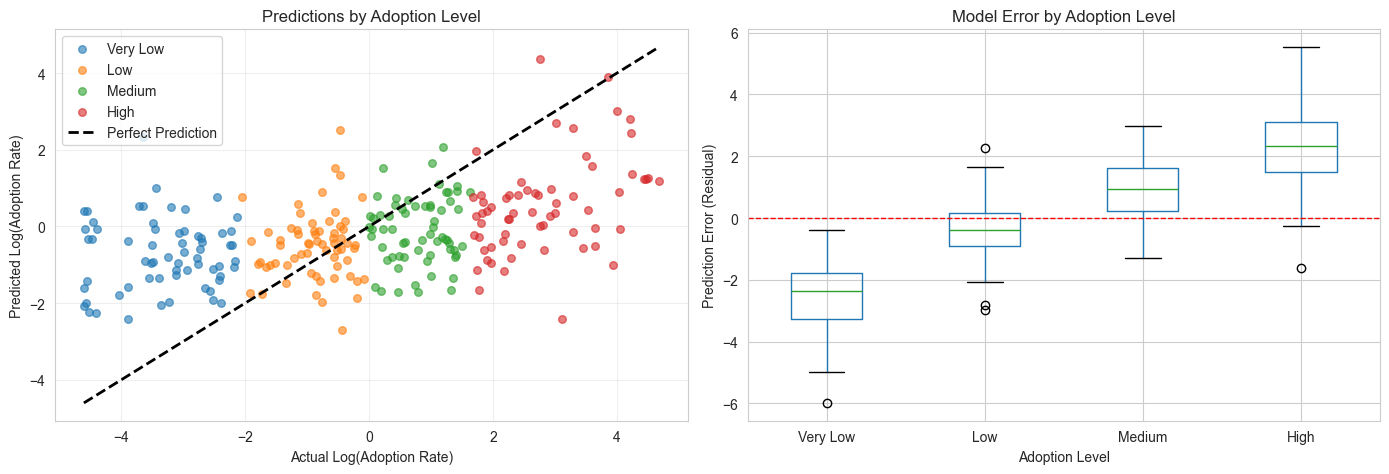

In [37]:
# Analyze model performance by adoption level
test_results = pd.DataFrame({
    'actual': y_test,
    'predicted': y_pred,
    'adoption_level': stratify_labels.iloc[X_test.index],
    'residual': y_test - y_pred
})

# Plot residuals by adoption level
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Actual vs Predicted by adoption level
for quartile in ['Very Low', 'Low', 'Medium', 'High']:
    subset = test_results[test_results['adoption_level'] == quartile]
    axes[0].scatter(subset['actual'], subset['predicted'], 
                    label=quartile, alpha=0.6, s=30)

axes[0].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'k--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Log(Adoption Rate)')
axes[0].set_ylabel('Predicted Log(Adoption Rate)')
axes[0].set_title('Predictions by Adoption Level')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Residual distribution by level
test_results.boxplot(column='residual', by='adoption_level', ax=axes[1])
axes[1].set_xlabel('Adoption Level')
axes[1].set_ylabel('Prediction Error (Residual)')
axes[1].set_title('Model Error by Adoption Level')
axes[1].axhline(0, color='red', linestyle='--', linewidth=1)
plt.suptitle('')  # Remove auto-title

plt.tight_layout()
plt.show()

## 5. Model Interpretation: Feature Importance

Examine coefficient magnitudes to identify which features most strongly influence solar adoption.

In [38]:
# Extract coefficients
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': best_model.coef_
})

# Sort by absolute magnitude
coefficients['Abs_Coefficient'] = coefficients['Coefficient'].abs()
coefficients = coefficients.sort_values('Abs_Coefficient', ascending=False)

print("=" * 70)
print("Feature Coefficients (Sorted by Magnitude)")
print("=" * 70)
print(f"\nIntercept: {best_model.intercept_:.4f}")
print(f"\nTop 15 Most Important Features:")
print(coefficients[['Feature', 'Coefficient']].head(15).to_string(index=False))

# Count non-zero coefficients (features selected by L1 penalty)
non_zero = (coefficients['Coefficient'] != 0).sum()
print(f"\nFeatures with non-zero coefficients: {non_zero}/{len(coefficients)}")
print(f"Features zeroed out by L1 penalty: {len(coefficients) - non_zero}")

Feature Coefficients (Sorted by Magnitude)

Intercept: -0.0990

Top 15 Most Important Features:
                Feature  Coefficient
      log_median_income     0.624475
          log_pct_black    -0.555257
    urbanicity_Suburban    -0.435948
       urbanicity_Urban    -0.433601
pct_bachelors_or_higher     0.387399
   total_solar_programs     0.355690
     homeownership_rate    -0.343447
       log_pct_hispanic    -0.272579
 pct_white_non_hispanic    -0.194939
 single_family_home_pct     0.124631
     avg_household_size    -0.121920
 log_population_density     0.004131
    has_solar_incentive     0.000000
       has_net_metering     0.000000

Features with non-zero coefficients: 12/14
Features zeroed out by L1 penalty: 2


### 5.1 Visualize Feature Coefficients

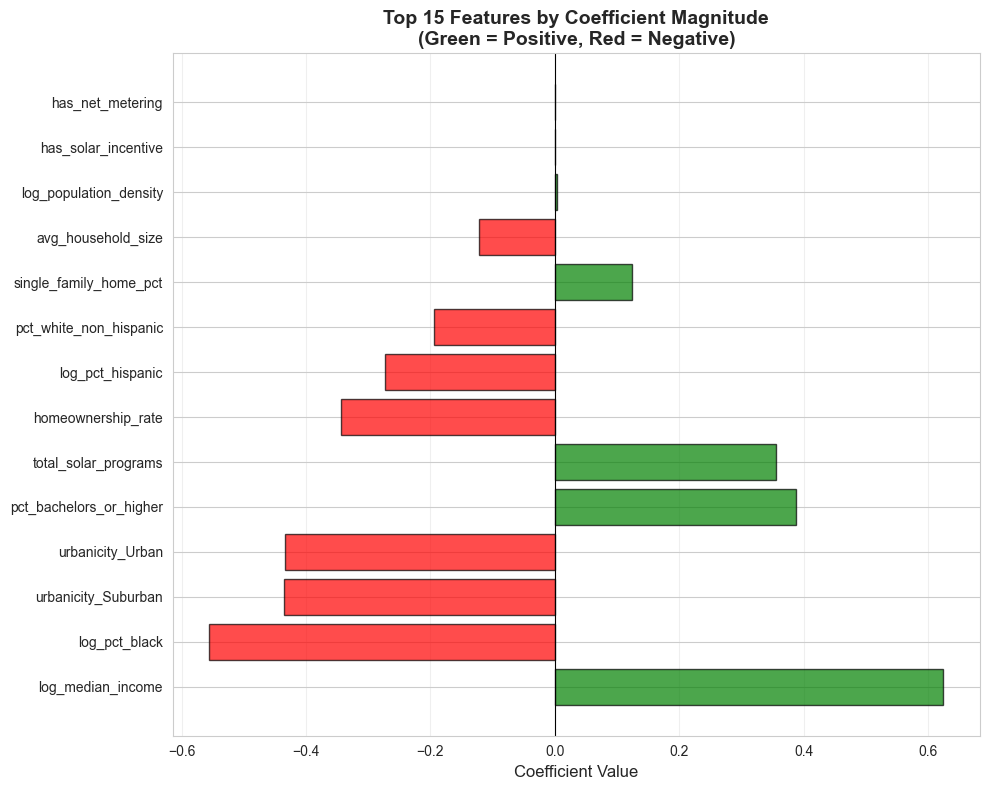

 Coefficient plot generated


In [39]:
# Bar plot of top features by coefficient magnitude
top_n = 15
top_features = coefficients.head(top_n)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ['green' if x > 0 else 'red' for x in top_features['Coefficient']]
ax.barh(range(len(top_features)), top_features['Coefficient'], color=colors, alpha=0.7, edgecolor='black')
ax.set_yticks(range(len(top_features)))
ax.set_yticklabels(top_features['Feature'])
ax.set_xlabel('Coefficient Value', fontsize=12)
ax.set_title(f'Top {top_n} Features by Coefficient Magnitude\n(Green = Positive, Red = Negative)', 
             fontsize=14, fontweight='bold')
ax.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
ax.grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print(" Coefficient plot generated")

## 6. Interpretation & Insights

**Positive coefficients:** Features associated with higher solar adoption  
**Negative coefficients:** Features associated with lower solar adoption (potential barriers)

**Key Questions:**
1. Which features have the largest positive coefficients?
2. Which features have the largest negative coefficients (barriers)?
3. Do policy variables (net metering, incentives) show significant effects?
4. How do demographic factors (income, education, race) relate to adoption?

For interpretation of findings + business implications, see [RESULTS.md](RESULTS.md).

In [40]:
# Separate positive and negative coefficients
positive_coef = coefficients[coefficients['Coefficient'] > 0].sort_values('Coefficient', ascending=False)
negative_coef = coefficients[coefficients['Coefficient'] < 0].sort_values('Coefficient')

print("=" * 70)
print("Interpretation: Factors Associated with Solar Adoption")
print("=" * 70)

print("\n TOP POSITIVE FACTORS (Enabling Factors):")
print(positive_coef[['Feature', 'Coefficient']].head(10).to_string(index=False))

print("\n TOP NEGATIVE FACTORS (Barriers):")
print(negative_coef[['Feature', 'Coefficient']].head(10).to_string(index=False))

# Check policy variables specifically
policy_features = ['has_net_metering', 'has_solar_incentive']
policy_coefs = coefficients[coefficients['Feature'].isin(policy_features)]

print("\n  POLICY EFFECTS:")
print(policy_coefs[['Feature', 'Coefficient']].to_string(index=False))

Interpretation: Factors Associated with Solar Adoption

 TOP POSITIVE FACTORS (Enabling Factors):
                Feature  Coefficient
      log_median_income     0.624475
pct_bachelors_or_higher     0.387399
   total_solar_programs     0.355690
 single_family_home_pct     0.124631
 log_population_density     0.004131

 TOP NEGATIVE FACTORS (Barriers):
               Feature  Coefficient
         log_pct_black    -0.555257
   urbanicity_Suburban    -0.435948
      urbanicity_Urban    -0.433601
    homeownership_rate    -0.343447
      log_pct_hispanic    -0.272579
pct_white_non_hispanic    -0.194939
    avg_household_size    -0.121920

  POLICY EFFECTS:
            Feature  Coefficient
has_solar_incentive          0.0
   has_net_metering          0.0


## 7. Save Results

In [41]:
# Save coefficient results

coefficients.to_csv('model_results/model_coefficients.csv', index=False)

print(" Results saved:")
print(f"  - model_results/model_coefficients.csv")

# Summary statistics
summary = {
    'r2_score': r2,
    'rmse_log': rmse_log,
    'mae_log': mae_log,
    'rmse_orig': rmse_orig,
    'mae_orig': mae_orig,
    'best_alpha': grid_search.best_params_['alpha'],
    'best_l1_ratio': grid_search.best_params_['l1_ratio'],
    'n_features_selected': non_zero,
    'n_counties_train': len(X_train),
    'n_counties_test': len(X_test)
}

summary_df = pd.DataFrame([summary])
summary_df.to_csv('model_results/model_summary.csv', index=False)

print(f"  - model_results/model_summary.csv")
print("\n Modeling complete!")

 Results saved:
  - model_results/model_coefficients.csv
  - model_results/model_summary.csv

 Modeling complete!


### Appendix Diagnostic on unexpected results


DIAGNOSTIC: Homeownership Univariate Regression

 Question: What is homeownership's TRUE marginal effect?
   (Does coefficient flip sign when other features are removed?)

 Homeownership Coefficient Comparison:
Model                           Coefficient       R²
Univariate (isolated):              -0.1420    0.002
Full model (with controls):         -0.3434    0.208
Coefficient change:                 -0.2015

 Interpretation:
    CONSISTENT NEGATIVE EFFECT
   → Homeownership genuinely predicts lower adoption
   → This is a REAL finding (not artifact)
   → Possible explanation: High-homeownership counties are rural/low-income areas


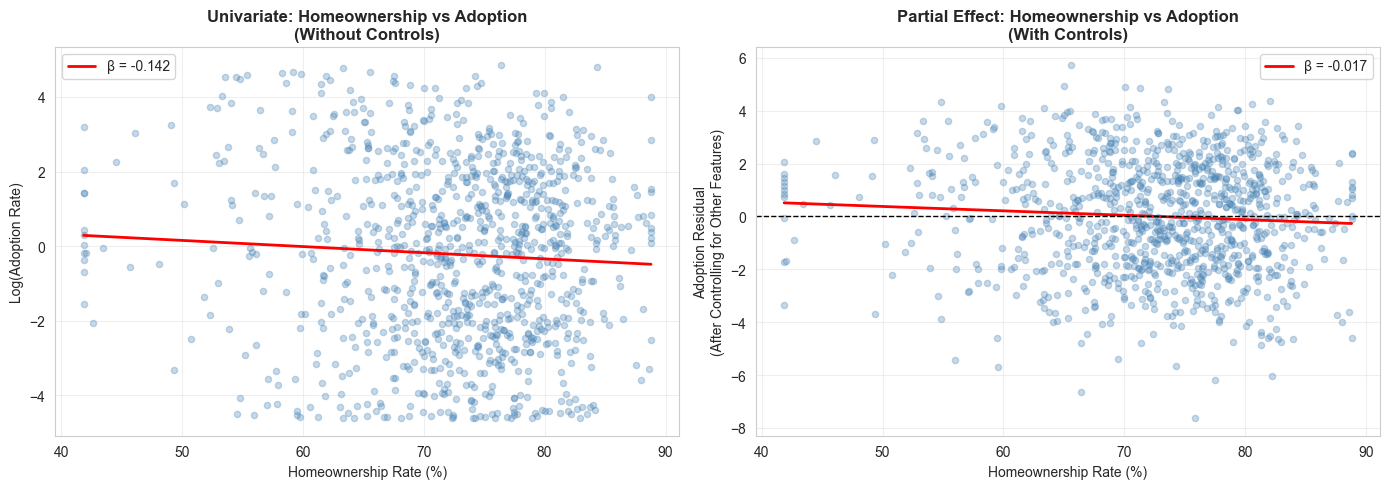


 Homeownership Correlation with Other Features:
homeownership_rate        1.000000
single_family_home_pct    0.619663
log_median_income         0.033082
urbanicity_Suburban      -0.103050
urbanicity_Urban         -0.467974

  High correlations (|r| > 0.5) suggest multicollinearity:
   • single_family_home_pct: r = 0.620

 Diagnostic Complete


In [42]:
# ============================================================================
# DIAGNOSTIC: Univariate Regression for Homeownership
# ============================================================================

print("\n" + "=" * 70)
print("DIAGNOSTIC: Homeownership Univariate Regression")
print("=" * 70)
print("\n Question: What is homeownership's TRUE marginal effect?")
print("   (Does coefficient flip sign when other features are removed?)")

# Train model with ONLY homeownership_rate as predictor
X_train_univariate = X_train_scaled[['homeownership_rate']].copy()
X_test_univariate = X_test_scaled[['homeownership_rate']].copy()

# Use simple linear regression (no regularization needed for 1 feature)
from sklearn.linear_model import LinearRegression

model_univariate = LinearRegression()
model_univariate.fit(X_train_univariate, y_train)

# Get coefficient and R²
homeownership_coef_univariate = model_univariate.coef_[0]
y_pred_univariate = model_univariate.predict(X_test_univariate)
r2_univariate = r2_score(y_test, y_pred_univariate)

# Compare to full model
homeownership_coef_full = coefficients[coefficients['Feature'] == 'homeownership_rate']['Coefficient'].values[0]

print("\n Homeownership Coefficient Comparison:")
print(f"{'Model':<30} {'Coefficient':>12} {'R²':>8}")
print("=" * 60)
print(f"{'Univariate (isolated):':<30} {homeownership_coef_univariate:>12.4f} {r2_univariate:>8.3f}")
print(f"{'Full model (with controls):':<30} {homeownership_coef_full:>12.4f} {r2:>8.3f}")
print(f"{'Coefficient change:':<30} {homeownership_coef_full - homeownership_coef_univariate:>12.4f}")

# Interpretation
print("\n Interpretation:")
if homeownership_coef_univariate > 0 and homeownership_coef_full < 0:
    print("     SIGN FLIP DETECTED!")
    print("   → Homeownership is POSITIVE predictor when isolated")
    print("   → But becomes NEGATIVE in full model")
    print("   → Conclusion: Suppressor effect due to multicollinearity")
    print("   → Other variables (single-family homes, urbanicity) capture homeownership's effect")
elif homeownership_coef_univariate < 0 and homeownership_coef_full < 0:
    print("    CONSISTENT NEGATIVE EFFECT")
    print("   → Homeownership genuinely predicts lower adoption")
    print("   → This is a REAL finding (not artifact)")
    print("   → Possible explanation: High-homeownership counties are rural/low-income areas")
elif abs(homeownership_coef_univariate) < 0.01:
    print("   ℹ  WEAK MARGINAL EFFECT")
    print("   → Homeownership alone has minimal predictive power")
    print("   → Effect only emerges when controlling for other variables")
else:
    print("   → Homeownership coefficient is stable across specifications")

# Visualize: Scatter plot with regression line
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Left: Univariate relationship (raw data)
axes[0].scatter(X_train['homeownership_rate'], y_train, alpha=0.3, s=20, color='steelblue')
axes[0].plot(X_train['homeownership_rate'].sort_values(), 
             model_univariate.predict(X_train_univariate.loc[X_train['homeownership_rate'].sort_values().index]),
             color='red', linewidth=2, label=f'β = {homeownership_coef_univariate:.3f}')
axes[0].set_xlabel('Homeownership Rate (%)')
axes[0].set_ylabel('Log(Adoption Rate)')
axes[0].set_title('Univariate: Homeownership vs Adoption\n(Without Controls)', fontweight='bold')
axes[0].legend()
axes[0].grid(alpha=0.3)

# Right: Partial residual plot (after controlling for other variables)
# This shows homeownership's effect AFTER removing other predictors' influence
other_features = [f for f in X_train_scaled.columns if f != 'homeownership_rate']
X_train_other = X_train_scaled[other_features]

# Train model on other features only
model_other = LinearRegression()
model_other.fit(X_train_other, y_train)

# Get residuals (what's left AFTER other features explain adoption)
y_residual = y_train - model_other.predict(X_train_other)

# Plot homeownership vs residuals
axes[1].scatter(X_train['homeownership_rate'], y_residual, alpha=0.3, s=20, color='steelblue')

# Add regression line for residuals
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(X_train['homeownership_rate'], y_residual)
axes[1].plot(X_train['homeownership_rate'].sort_values(),
             slope * X_train['homeownership_rate'].sort_values() + intercept,
             color='red', linewidth=2, label=f'β = {slope:.3f}')

axes[1].set_xlabel('Homeownership Rate (%)')
axes[1].set_ylabel('Adoption Residual\n(After Controlling for Other Features)')
axes[1].set_title('Partial Effect: Homeownership vs Adoption\n(With Controls)', fontweight='bold')
axes[1].legend()
axes[1].grid(alpha=0.3)
axes[1].axhline(0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

# Additional check: Correlation with other housing features
print("\n Homeownership Correlation with Other Features:")
housing_features = ['homeownership_rate', 'single_family_home_pct', 'urbanicity_Urban', 
                    'urbanicity_Suburban', 'log_median_income']
available_features = [f for f in housing_features if f in X_train.columns]

correlation_matrix = X_train[available_features].corr()['homeownership_rate'].sort_values(ascending=False)
print(correlation_matrix.to_string())

print("\n  High correlations (|r| > 0.5) suggest multicollinearity:")
high_corr = correlation_matrix[abs(correlation_matrix) > 0.5]
if len(high_corr) > 1:  # Exclude self-correlation
    for feat, corr_val in high_corr.items():
        if feat != 'homeownership_rate':
            print(f"   • {feat}: r = {corr_val:.3f}")
else:
    print("    No strong correlations detected")

print("\n" + "=" * 70)
print(" Diagnostic Complete")
print("=" * 70)